### Tools for reading the data

In [2]:
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import glob

from IPython.display import display, JSON, clear_output

In [3]:
from optosim.simulation.event_reader import EventReader, show_data

import pandas as pd

#### Check all available data

In [4]:
data_dir = '/data/xenon/acolijn/optosim/data'
show_data(data_dir)

Found 12 subdirectories
Subdirectories:
['9994', '9997', '9998', '9999', 'mc0000', 'mc0001', 'mc0002', 'mc0003', 'mc0004', 'mc0005', 'mc0006', 'mc9999']
File /data/xenon/acolijn/optosim/data/9994/9994.0000.hd5f is currently open by another process. Skipping...


,subdir,detector,nevents,nphoton_per_event,set_no_scatter,set_experimental_scatter_model,radius
0,9997,XENONnT,10,"[1000, 25000]",False,True,65.0
1,9998,XAMS,100,"[1000, 25000]",False,True,3.2
2,9999,XAMS,100,"[1000, 25000]",NaN,NaN,3.2
3,mc0000,XAMS,1000,100000,False,True,3.2
4,mc0001,XAMS,10000,10000,False,True,3.2
5,mc0002,XAMS,10000,10000,True,True,3.2
6,mc0003,XAMS,10000,10000,False,False,3.2
7,mc0004,XAMS,10000,10000,False,True,3.2
8,mc0005,XAMS,10000,10000,True,True,3.2
9,mc0006,XAMS,10000,"[1000, 25000]",False,True,3.2


#### Get all the file names and initialize the data reader class

In [5]:
files = glob.glob('/data/xenon/acolijn/optosim/data/9997/*.hd5')
print(files)

['/data/xenon/acolijn/optosim/data/9997/9997.0000.hd5']


#### Loop over the events

1. maximum number of events can be set with nmax
2. use plot=True to show the events 

Note: the event loop below assumes a 2x2 detector. For other dimensions the code needs to be adapted

In [6]:
plot=True
nmax=1000000

In [7]:
%%time
events = EventReader(files)

n = 0


# this if where the data goes....
data_dict = { 
    'x': [],
    'y': [],
    'q_b': [],
    'q_l': [],
    'q_tot': []
}

#
# loop over evnts...
#
for ev in events:
    if n%1000 == 0:
        print('processed ',n,'events')#, events.print_event(ev))
    n+=1
    
    # if you want to show the events
    if plot:
        nph = ev['nphoton'][()]
        
        if nph < 2000000:
            print('nphoton = ',nph)

            events.show_event(ev)
            response = input("Press Enter to continue to the next event or 'q' to quit...")

            if response.lower() == 'q':
                print("Quit the event display......")
                break
        
            clear_output(wait=True)
    
    
    # retrieve the true hit position
    x_true = ev['true_position'][()]
    data_dict['x'].append(x_true[0])
    data_dict['y'].append(x_true[1])
    
    # get the data from the top PMT    
    pmt = ev['pmt_top'][()]
    qtot = float(np.sum(pmt))
    data_dict['q_b'].append((pmt[0][0] + pmt[1][0]))
    data_dict['q_l'].append((pmt[0][0] + pmt[0][1]))
    data_dict['q_tot'].append(qtot)
    
    if n>nmax:
        break
            
# write the data to a dataFrame
df = pd.DataFrame(data_dict)
df['r'] = np.sqrt(df['x']**2+df['y']**2)
df['q_tb'] = df['q_b']/df['q_tot']
df['q_lr'] = df['q_l']/df['q_tot']


events.reset()

CPU times: user 13.5 s, sys: 2.84 s, total: 16.4 s
Wall time: 1min 12s


#### Plot the charge ratio

Two plots: (i) $Q_L / Q_{tot}$ as a function of $x$ (ii) $Q_B / Q_{tot}$ as a function of $y$.

Text(0, 0.5, '$Q_B / Q_{tot}$')

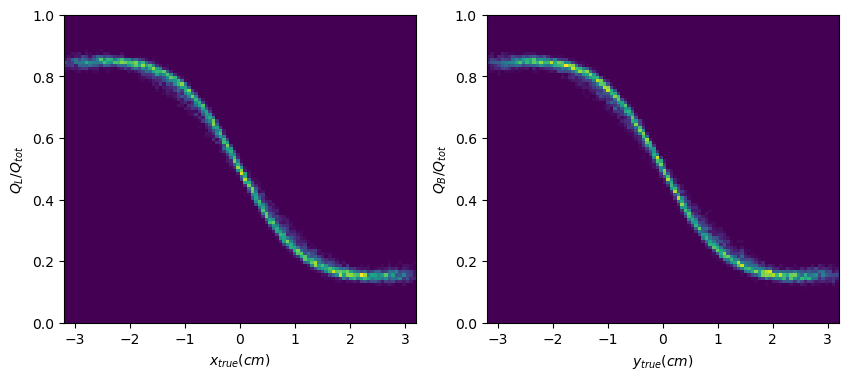

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

R = events.config['geometry']['radius']

h1 = axs[0].hist2d(df['x'],df['q_lr'],bins=(100,100), range=((-R,R),(0,1)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L / Q_{tot}$')

h2 = axs[1].hist2d(df['y'],df['q_tb'],bins=(100,100), range=((-R,R),(0,1)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B / Q_{tot}$')

Text(0, 0.5, '$Q_B$')

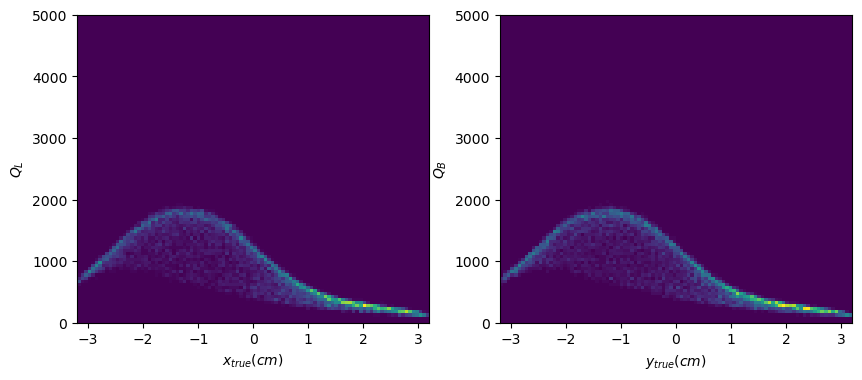

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

R = events.config['geometry']['radius']

h1 = axs[0].hist2d(df['x'],df['q_l'],bins=(100,100), range=((-R,R),(0,5000)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L$')

h2 = axs[1].hist2d(df['y'],df['q_b'],bins=(100,100), range=((-R,R),(0,5000)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B$')

.... and also $Q_{tot}$ as a function of radius.

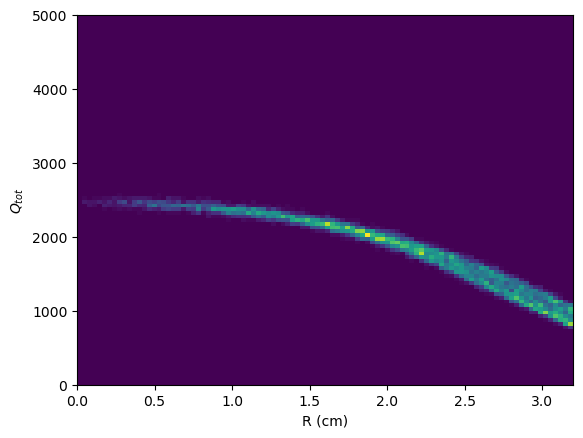

In [77]:
xp = np.array(xp)
yp = np.array(yp)
R = events.config['geometry']['radius']

r2 = np.sqrt(df['x']**2+df['y']**2)
h=plt.hist2d(r2,df['q_tot'],bins=100, range=((0,R),(0,5000)))
plt.xlabel('R (cm)')
plt.ylabel('$Q_{tot}$')
plt.show()

In [10]:
import numpy as np
# I want to open the hdf5 files and read the data
import h5py
import matplotlib.pyplot as plt
import glob
from IPython.display import display, JSON, clear_output

# this is the directory where the data is stored
files = glob.glob('/data/xenon/acolijn/optosim/data/9999/*.hdf5')
print(files)

with h5py.File(files[0], 'r') as f:
    config = f.attrs['config']

    all_fine_bot = f['events/fine_bot'][:]

print(all_fine_bot.shape)

print(all_fine_bot[0])


file = files[0]

['/data/xenon/acolijn/optosim/data/9999/9999.0000.hd5f']
(100, 20, 20)
[[ 0  4 13 22 24 46 58 40 39 34 10 28 16 15 13 14 10  5  1  0]
 [ 3 13 28 34 52 76 17  9 22 12  6 15 22 21 17 10 13 14  6  3]
 [ 9 17 18 29 51  6 17 14 19 10  7 17  9 14 16 11 11  8 14  7]
 [ 8  9 12 34 13  9 12 12 13 13 10  9 11 10 15 15  6 12 12 10]
 [ 4  8 25 22  6  8 14 15 12  9 15 12  8 11  8  4 15 10  8 11]
 [ 5 13 19  6 10  8 10 14 12 11 15  9 13 20 25  7 13 13 13 10]
 [ 2 11 14 11  9  6  7 12  6  9  7 12 14 14 10 20 17  9 10 18]
 [ 5  9 15  3  8  6  4  4 10 14  9 11  5 15 13 10 13 14 15 12]
 [ 7  6 10  7  5  7  8 10  8 11  6  7 11  7 19 11  9  6 14 15]
 [ 5  1  5  9  8 13 11  6  7  7 10 11  7  8 16 11 11 15 15 20]
 [ 5  7 13  8  6  5  6  5  9 11 13 12  8  8 12 11 10  9 12 12]
 [ 8  6  8  6 14 14  7 12 10  7 13  7  4 13 11 11  7 14  4 12]
 [ 7  9  6  8 12  4  8  5  7 12  9 12 10 13 15 13 11 16 14 13]
 [ 2  3 10  6  7 15  6  7 11 11  9 10  9 11 13 12 12 12 15 15]
 [ 2 11  7  9  9 10  6  8  7  8  8 10  5 21 15 

In [15]:
import h5py

def print_structure(file, indent=''):
    for key, item in file.items():
        if isinstance(item, h5py.Dataset):
            print(indent + key + ": Dataset")
        elif isinstance(item, h5py.Group):
            print(indent + key + ": Group")
            print_structure(item, indent + '  ')
        print_attributes(item, indent + '  ')

def print_attributes(item, indent):
    attrs = item.attrs
    for attr_name, attr_value in attrs.items():
        print(indent + "[Attribute] " + attr_name + ":", attr_value)

filename = file
with h5py.File(filename, 'r') as f:
    print_structure(f)
    print(f.attrs['config'])




events: Group
  fine_bot: Dataset
  fine_top: Dataset
  nphoton: Dataset
  number: Dataset
  pmt_bot: Dataset
  pmt_top: Dataset
  true_position: Dataset
{"detector": "XAMS", "nevents": 100, "nphoton_per_event": [1000, 25000], "photon_zgen": 0.1, "geometry": {"type": "cylinder", "radius": 3.2, "ztop": 1.2, "zliq": 0.0, "zbot": -6.7, "ptfe_zmin": -5.32, "ptfe_zmax": -0.25}, "npmt_xy": 2, "pmt": {"type": "square", "size": 2.54, "ndivs": 10}}
